In [8]:
!pip install qiskit
!pip install qiskit_aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 2.5 MB/s eta 0:00:00


In [2]:
from qiskit import *
import numpy as np
from matplotlib import pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

We define some constants required for defining the problem. Feel free to play around with the constants in the next cell to modify the model problem.

In [3]:
#Number of qubits
n=6

#Circuit
phi=0.1 #time step
iterations=30 #iterations

#Potential
V=1.75

#Spatial Grid
N=2**n #grid points
xMin=-4
xMax=4
x = np.linspace(xMin,xMax, num=N)

Next, we define a wavefunction to simulate for our model problem. For simplicity, we will use a Gaussian wavefunction. However, more complex wavefunctions can be simulated by adjusting the following parameters.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


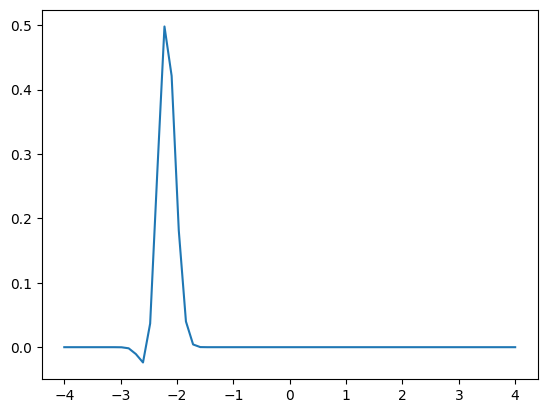

In [4]:
#Wavefunction
mu=-2.25
psi= (1/(np.sqrt(2*np.pi)*2*0.4)*np.exp(-(0.5*(x-mu)**2)/(2*0.016)))*np.exp(-300j*x)
psi/= np.sqrt(np.sum(np.abs(psi**2)))
plt.plot(x,psi)

Next, we define the quantum well (potential barrier) in our model. The position of this quantum well is determined by the gates here we apply the potential propagator. In this model, we apply $e^{(i  V  \phi)}$ to a qubit using a phase gate parameterized by $V {\phi}$. The potential and momentum operators are implemented using the Split Operator Fourier Transform Algorithm. The first qubit in the circuit serves as the ancillary qubit. Finally, we code a single time step of the split operator algorithm using all the propagators we defined earlier.

In [6]:
qubits=QuantumRegister(n+1)
splitOp=QuantumCircuit(qubits,name="splitOp")
'''potential operator'''
splitOp.ccx(3,4,0)
splitOp.cp(V*phi,0,5)
splitOp.ccx(3,4,0)
splitOp.barrier()
'''momentum operator'''
splitOp.append(QFT(n),qubits[1:])
for i in range(n):
  splitOp.p(phi/2**(n-3+i), n-i)
for i in range(n):
  for j in range(i+1,n):
    splitOp.cx(n-j,0)
    splitOp.cx(n-i,0)
    splitOp.p(phi*(2**(2-i-j)),0)
    splitOp.cx(n-i,0)
    splitOp.cx(n-j,0)
splitOp.append(QFT(n,inverse=True),qubits[1:])
splitOp.barrier()
splitOp.draw()

┌───┐           ┌───┐ ░                          ┌───┐┌───┐┌────────┐»
q1_0: ┤ X ├─■─────────┤ X ├─░──────────────────────────┤ X ├┤ X ├┤ P(0.2) ├»
      └─┬─┘ │         └─┬─┘ ░ ┌──────┐┌───────────────┐└─┬─┘└─┬─┘└────────┘»
q1_1: ──┼───┼───────────┼───░─┤0     ├┤ P(0.00039063) ├──┼────┼────────────»
        │   │           │   ░ │      │├───────────────┤  │    │            »
q1_2: ──┼───┼───────────┼───░─┤1     ├┤ P(0.00078125) ├──┼────┼────────────»
        │   │           │   ░ │      │└┬──────────────┤  │    │            »
q1_3: ──■───┼───────────■───░─┤2     ├─┤ P(0.0015625) ├──┼────┼────────────»
        │   │           │   ░ │  QFT │ ├─────────────┬┘  │    │            »
q1_4: ──■───┼───────────■───░─┤3     ├─┤ P(0.003125) ├───┼────┼────────────»
            │P(0.175)       ░ │      │ └┬────────────┤   │    │            »
q1_5: ──────■───────────────░─┤4     ├──┤ P(0.00625) ├───■────┼────────────»
                            ░ │      │  ├───────────┬┘        │            »
q1_6: ──────────────────────░─┤5     ├──┤ P(0.0125) ├─────────■────────────»
                            ░ └──────┘  └───────────┘                      »
«      ┌───┐┌───┐┌───┐┌───┐┌────────┐┌───┐┌───┐┌───┐┌───┐┌─────────┐┌───┐┌───┐»
«q1_0: ┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.1) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.05) ├┤ X ├┤ X ├»
«      └─┬─┘└─┬─┘└─┬─┘└─┬─┘└────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└─────────┘└─┬─┘└─┬─┘»
«q1_1: ──┼────┼────┼────┼──────────────┼────┼────┼────┼───────────────┼────┼──»
«        │    │    │    │              │    │    │    │               │    │  »
«q1_2: ──┼────┼────┼────┼──────────────┼────┼────┼────┼───────────────┼────┼──»
«        │    │    │    │              │    │    │    │               │    │  »
«q1_3: ──┼────┼────┼────┼──────────────┼────┼────■────┼───────────────┼────■──»
«        │    │    │    │              │    │         │               │       »
«q1_4: ──┼────┼────■────┼──────────────┼────■─────────┼───────────────┼───────»
«        │    │         │              │              │               │       »
«q1_5: ──┼────■─────────┼──────────────┼──────────────┼───────────────┼───────»
«        │              │              │              │               │       »
«q1_6: ──■──────────────■──────────────■──────────────■───────────────■───────»
«                                                                             »
«      ┌───┐┌───┐┌──────────┐┌───┐┌───┐┌───┐┌───┐┌───────────┐┌───┐┌───┐┌───┐»
«q1_0: ┤ X ├┤ X ├┤ P(0.025) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.0125) ├┤ X ├┤ X ├┤ X ├»
«      └─┬─┘└─┬─┘└──────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└───────────┘└─┬─┘└─┬─┘└─┬─┘»
«q1_1: ──┼────┼────────────────┼────┼────■────┼─────────────────┼────■────┼──»
«        │    │                │    │         │                 │         │  »
«q1_2: ──■────┼────────────────┼────■─────────┼─────────────────┼─────────┼──»
«             │                │              │                 │         │  »
«q1_3: ───────┼────────────────┼──────────────┼─────────────────┼─────────┼──»
«             │                │              │                 │         │  »
«q1_4: ───────┼────────────────┼──────────────┼─────────────────┼─────────■──»
«             │                │              │                 │            »
«q1_5: ───────┼────────────────┼──────────────┼─────────────────┼────────────»
«             │                │              │                 │            »
«q1_6: ───────■────────────────■──────────────■─────────────────■────────────»
«                                                                            »
«      ┌───┐┌─────────┐┌───┐┌───┐┌───┐┌───┐┌──────────┐┌───┐┌───┐┌───┐┌───┐»
«q1_0: ┤ X ├┤ P(0.05) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.025) ├┤ X ├┤ X ├┤ X ├┤ X ├»
«      └─┬─┘└─────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└──────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘»
«q1_1: ──┼───────────────┼────┼────┼────┼────────────────┼────┼────┼────┼──»
«        │               │    │    │    │                │    │    │    │  »
«q1_2: ──┼───────────────┼────┼────┼────┼────────────────┼────┼────■────┼──»
«   

Now, we construct our final circuit based on the number of iterations defined at the start of the code. We initialize the Gaussian wavefunction on our qubits and then apply the splitOp circuit for each time step. Each qubit (except the ancillary qubit) is measured into a classical bit. The circuit is executed on Qiskit’s qasm_simulator (a hardware backend could also be used in future works) and the results are stored in the answer dictionary:

In [7]:
q=QuantumRegister(n+1)
c=ClassicalRegister(n)
circuit=QuantumCircuit(q,c)
'''initialization'''
circuit.initialize(psi,q[1:])
circuit.barrier()
'''time steps'''
for i in range(iterations):
  circuit.append(splitOp,q[:])
'''measurement'''
for i in range(1,n+1):
  circuit.measure(i,i-1)
#circuit.draw('mpl')



NameError: name 'execute' is not defined

In [9]:
from qiskit_aer import AerSimulator

simulator = AerSimulator()

t_circuit = transpile(circuit, simulator)
#qobj = assemble(t_qpe, shots=shots)
results = simulator.run(t_circuit, shots=5000).result()
answer = results.get_counts()

In the final step, we plot our results on a histogram. The histogram presents a unique visualisation of a particle tunneling through a barrier from 001110 to 001111. This visualisation of the Quantum tunneling phenomenon is just one of the many possible use-cases of the Time evolution of quantum operators.

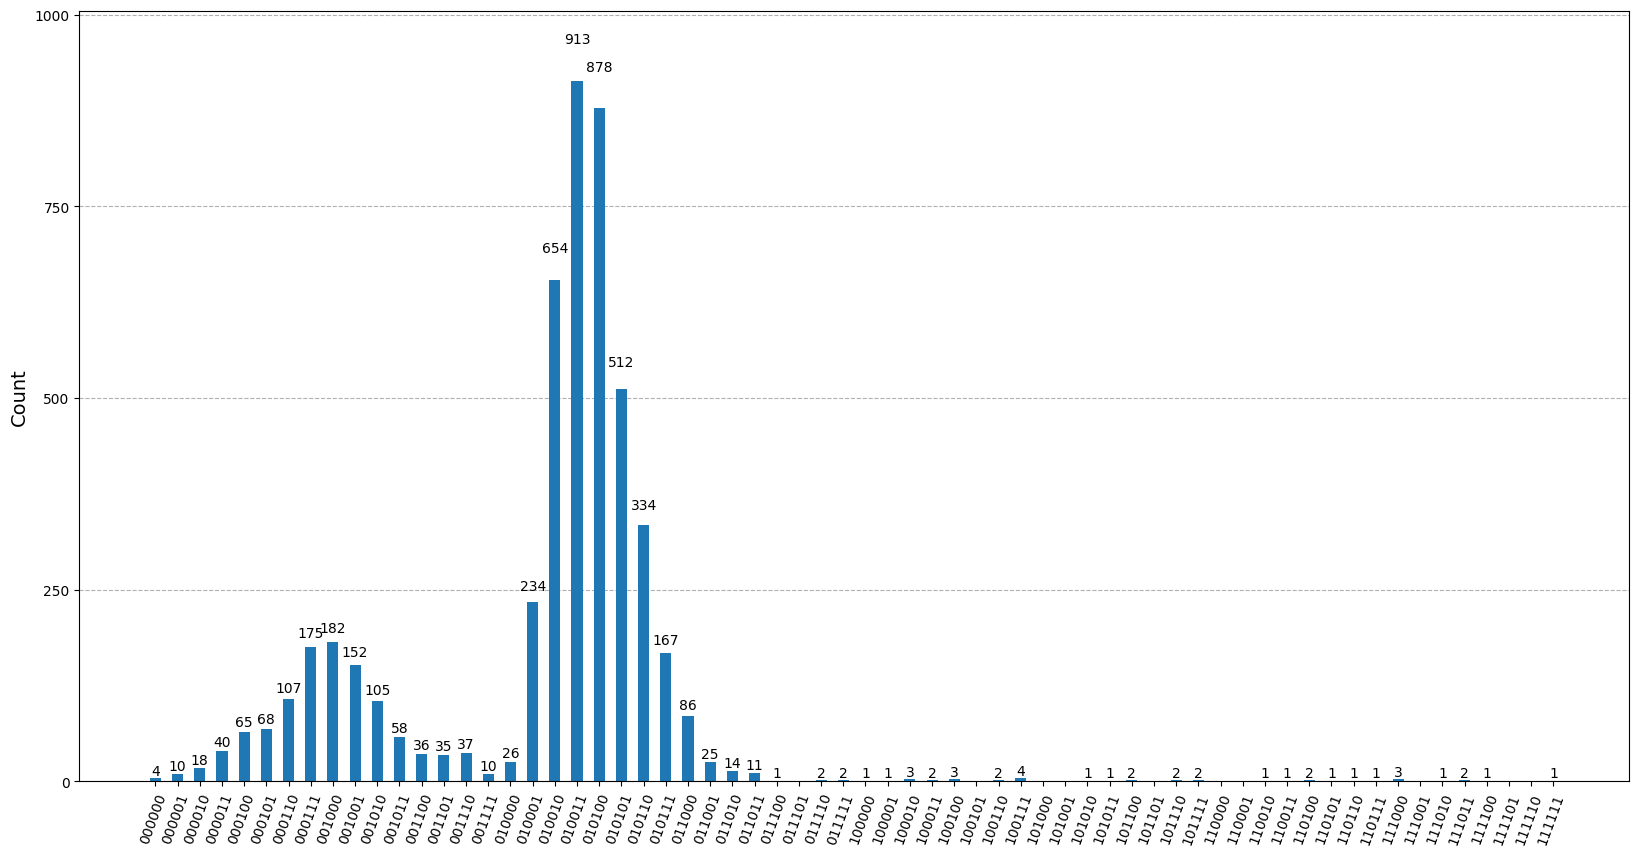

In [10]:
for a in range(N):
    s = bin(a)[2:]
    while len(s)!=6:
        s='0'+s
    if s not in answer.keys():
        answer[s] = 0
plot_histogram(answer, figsize = [20,10])

1.0000000000000002


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


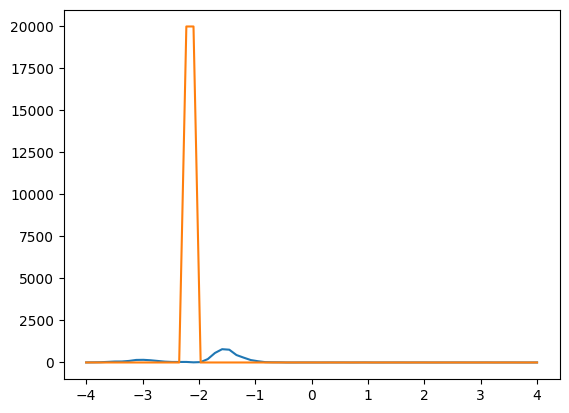

In [11]:
new_psi=np.zeros(N)
count=0
for key in sorted(answer.keys()):
  new_psi[count]=answer[key]
  count+=1
new_psi=new_psi/np.sqrt(np.sum(psi**2))
barrier=np.zeros(N)
barrier[14:16]=20000
print(np.sum(np.abs(psi**2)))
plt.plot(x,new_psi)
plt.plot(x,barrier)
plt.show()